# Lesther Santana

Source: https://www.kaggle.com/competitions/playground-series-s4e1/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from time import time

# For MICE imputation
from sklearn.experimental import enable_iterative_imputer  # This line is needed to use IterativeImputer
from sklearn.impute import IterativeImputer

# Other imputers if needed
from sklearn.impute import SimpleImputer, KNNImputer

## Problem Definition

A deep learning model trained on the Bank Customer Churn Prediction dataset generated this dataset.

This notebook's goal is to compare the performance of different imputation techniques using model performance and deviation of imputation strategies from the original values with a Bank Churn Dataset. Exited is The binary target variable.

## Load Dataset

In [2]:
data = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")

### Column info

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


### First 10 rows

In [4]:
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Data Cleaning

Goal:

* Convert discrete values from float to int
* Drop columns that identify a client like CustomerId and Surname

In [5]:
to_drop = ["CustomerId", "Surname", "id"]

In [6]:
data = data.drop(to_drop, axis=1, inplace=False)

In [7]:
data["Age"] = data['Age'].astype(int)
data["HasCrCard"] = data["HasCrCard"].astype(int)
data["IsActiveMember"] = data["IsActiveMember"].astype(int)
data["CreditScore"] = data["CreditScore"].astype(float)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  int32  
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int32  
 8   IsActiveMember   165034 non-null  int32  
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(3), int32(3), int64(3), object(2)
memory usage: 12.0+ MB


In [9]:
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668.0,France,Male,33,3,0.00,2,1,0,181449.97,0
1,627.0,France,Male,33,1,0.00,2,1,1,49503.50,0
2,678.0,France,Male,40,10,0.00,2,1,0,184866.69,0
3,581.0,France,Male,34,2,148882.54,1,1,1,84560.88,0
4,716.0,Spain,Male,33,5,0.00,2,1,1,15068.83,0


In [10]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125883,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867207,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## Exploratory Data Analysis (EDA)

The dataset has no missing values. So, before artificially creating and imputing those values, we will perform the Exploratory Data Analysis to understand the data better.

In [11]:
def eda_summary(df, target_column):
    """
    Perform EDA on df, including histograms and boxplots for numerical columns,
    colored by the binary target_column.
    """
    print("\nMissing values in each column:")
    print(df.isnull().sum())

    # Determine columns types
    num_columns = df.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Ensure target_column is binary and remove from num_columns if present
    if df[target_column].nunique() != 2:
        raise ValueError(f"Target column {target_column} is not binary.")
    if target_column in num_columns: num_columns.remove(target_column)
    if target_column in cat_columns: cat_columns.remove(target_column)

    # Plotting for numerical columns with target as hue
    for col in num_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=col, hue=target_column, kde=True, element="step", multiple="stack")
        plt.title(f'Distribution of {col} by {target_column}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=target_column, y=col)
        plt.title(f'Boxplot of {col} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

    # Count plots for categorical columns with target as hue
    for col in cat_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue=target_column)
        plt.title(f'Count of {col} by {target_column}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

In [12]:
data["Exited"].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [13]:
data["EstimatedSalary"].describe()

count    165034.000000
mean     112574.822734
std       50292.865585
min          11.580000
25%       74637.570000
50%      117948.000000
75%      155152.467500
max      199992.480000
Name: EstimatedSalary, dtype: float64


Missing values in each column:
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


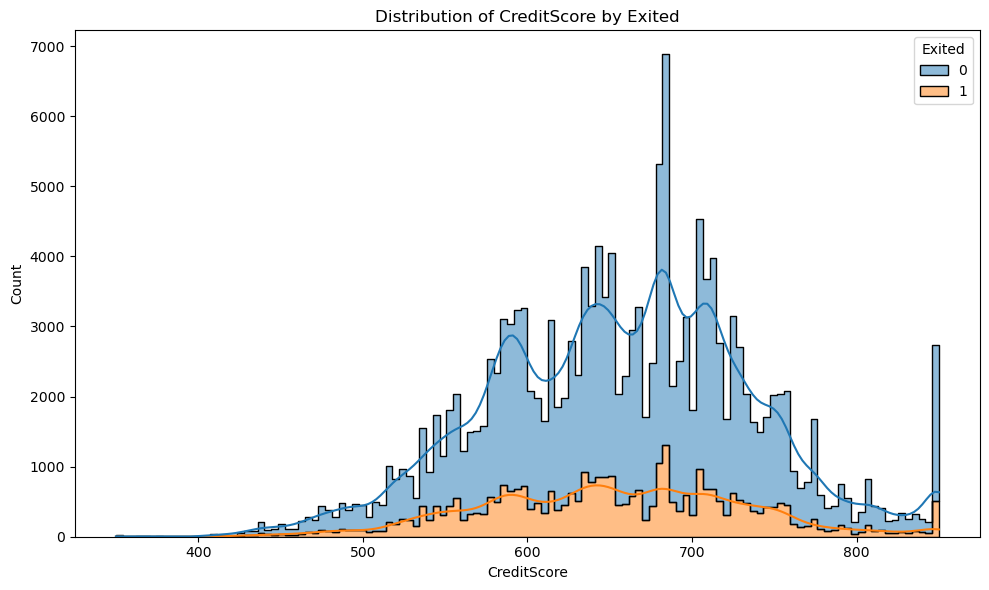

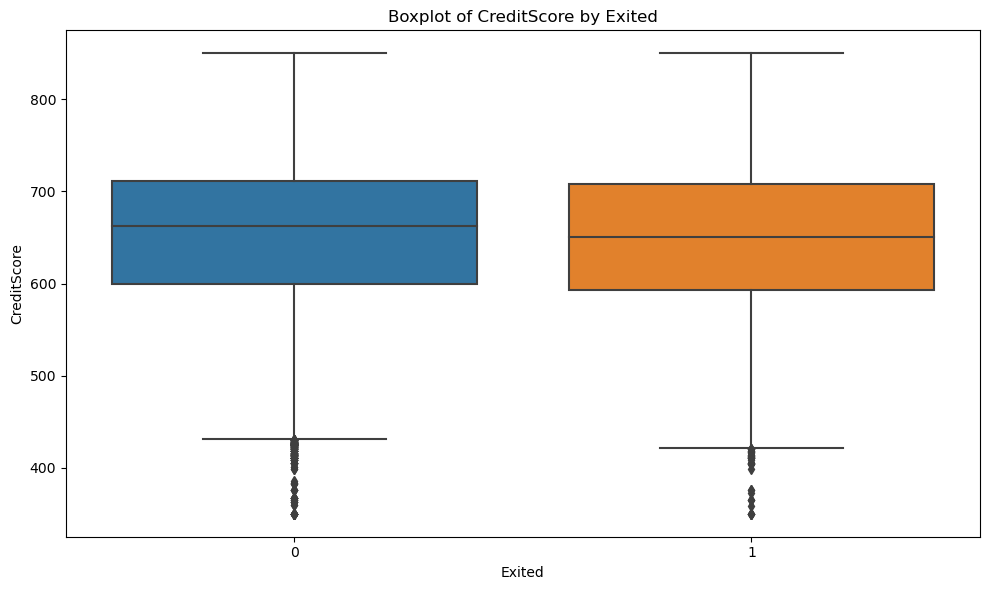

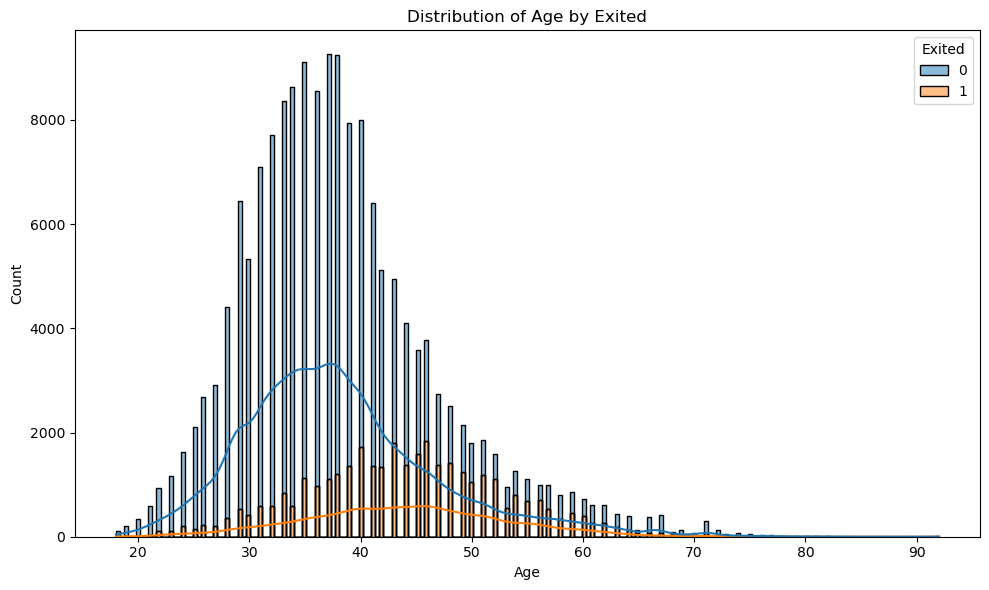

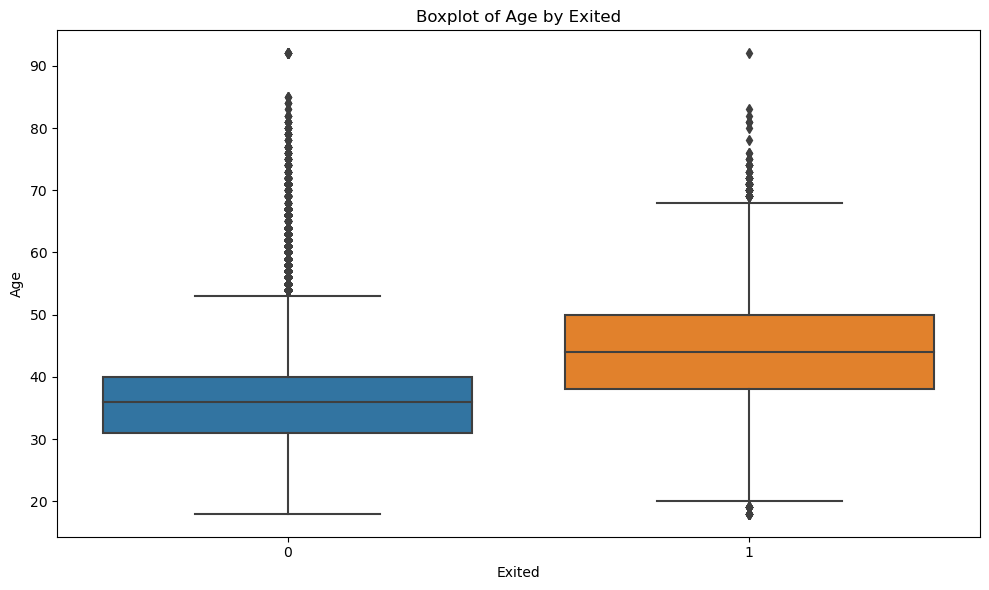

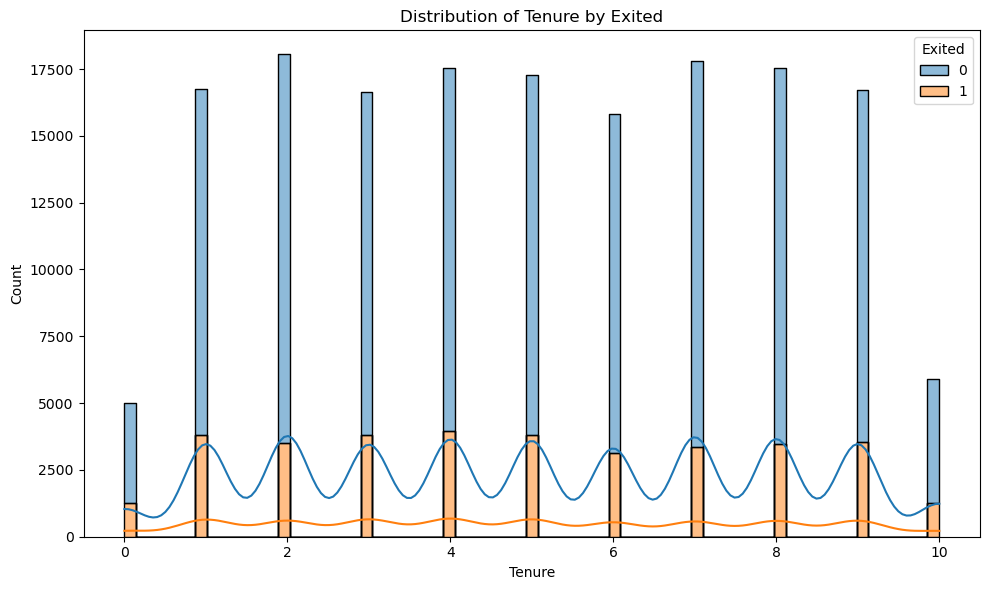

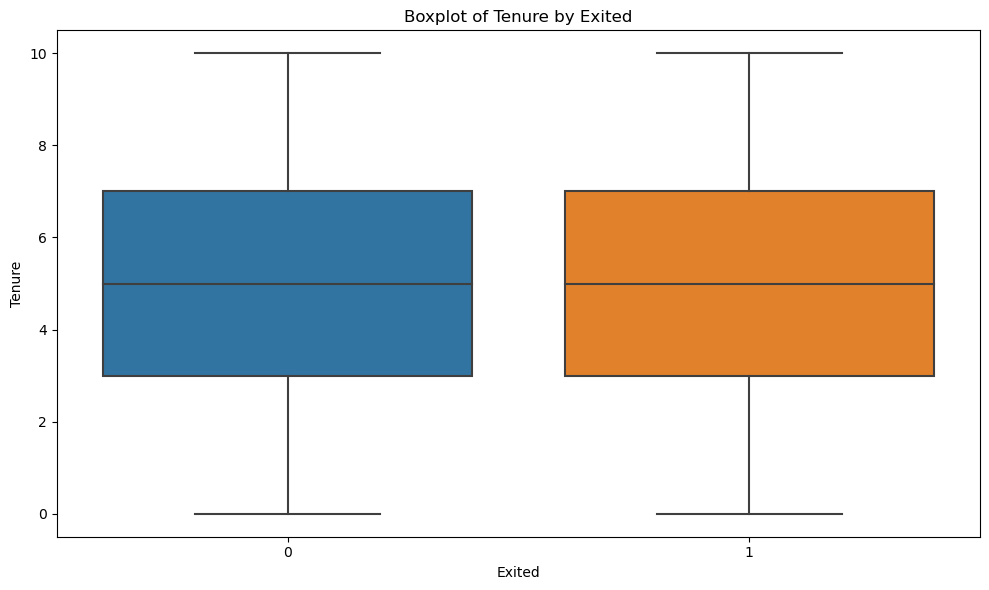

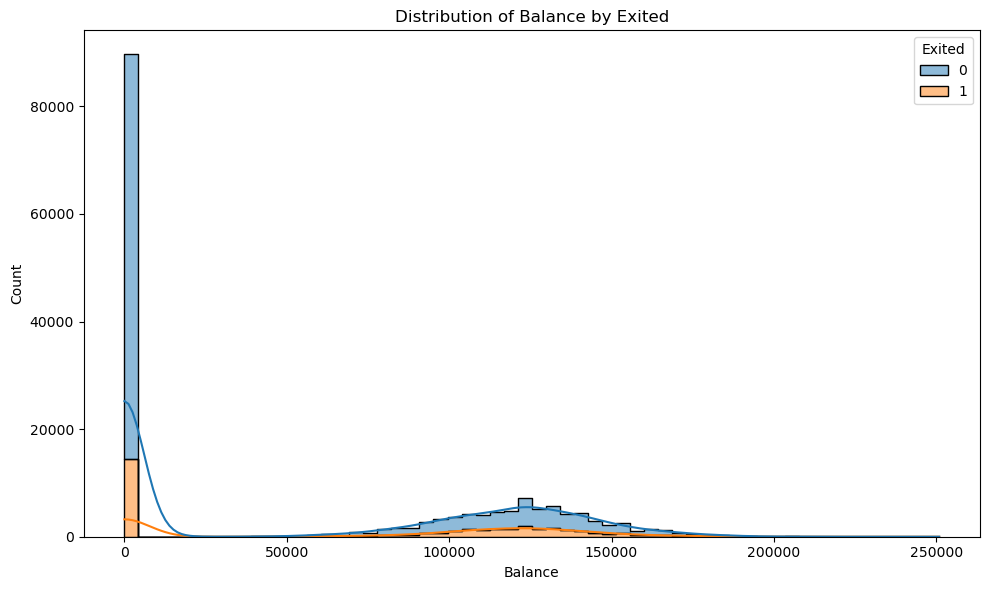

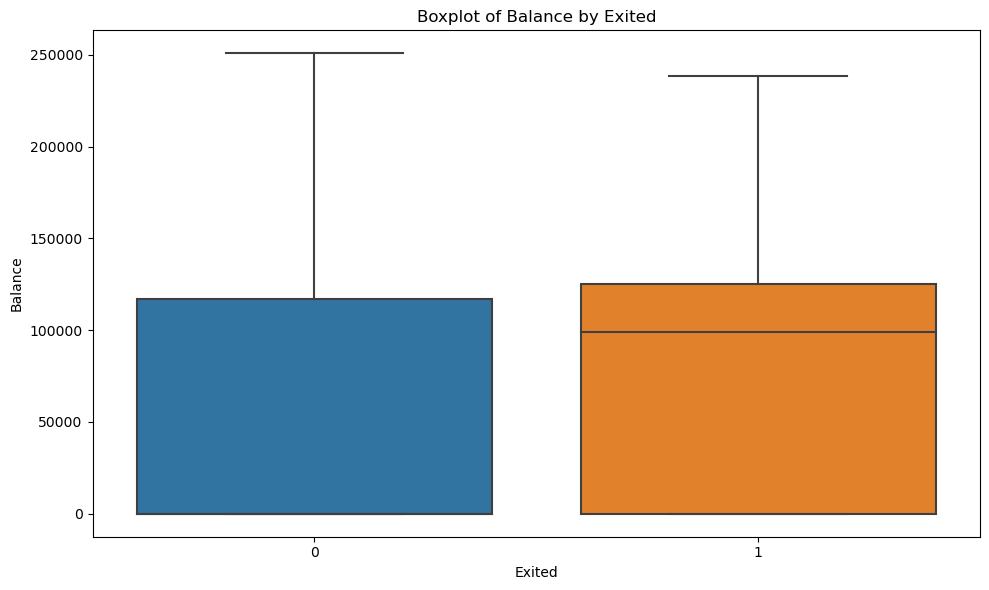

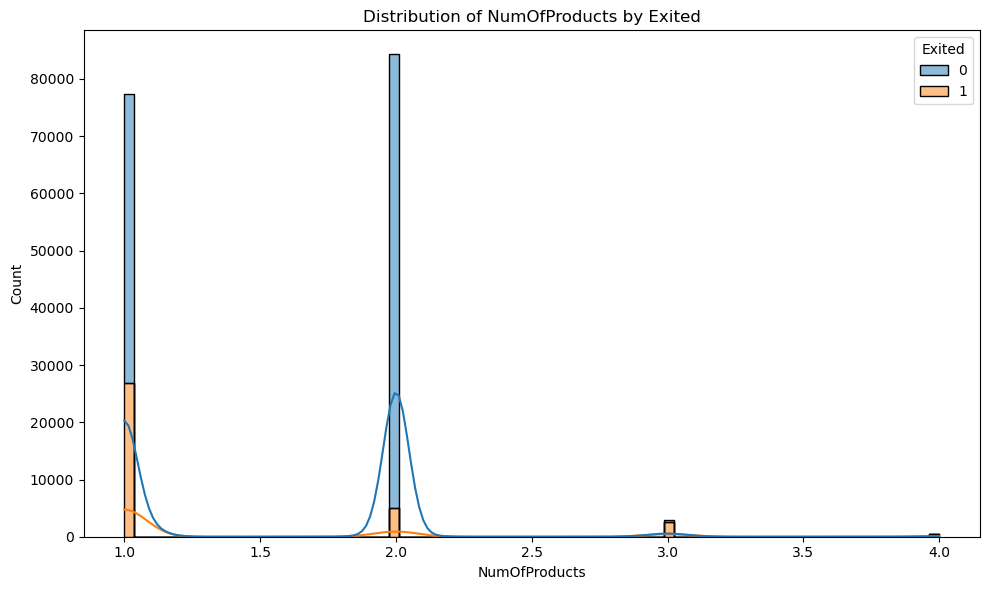

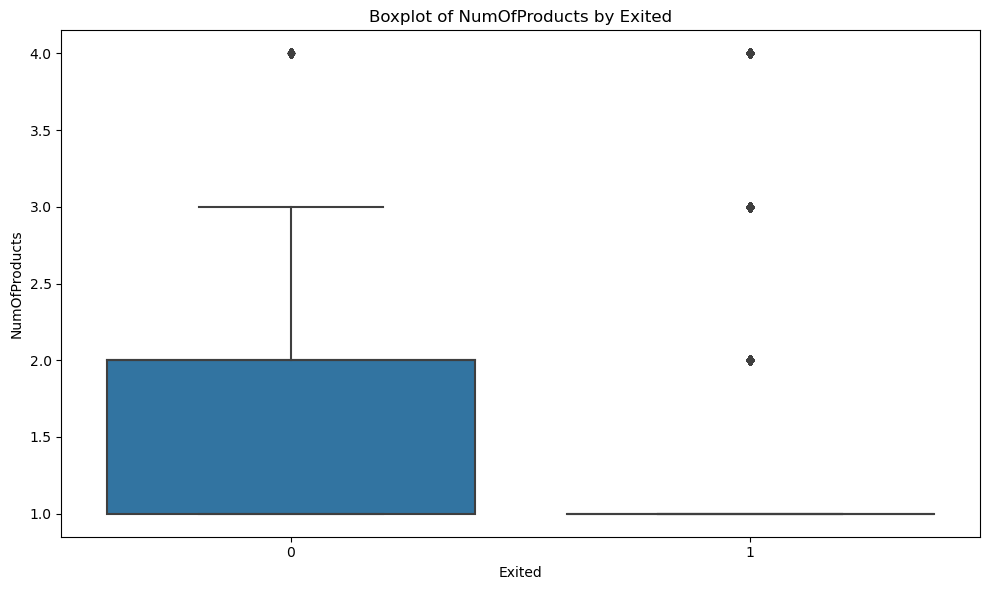

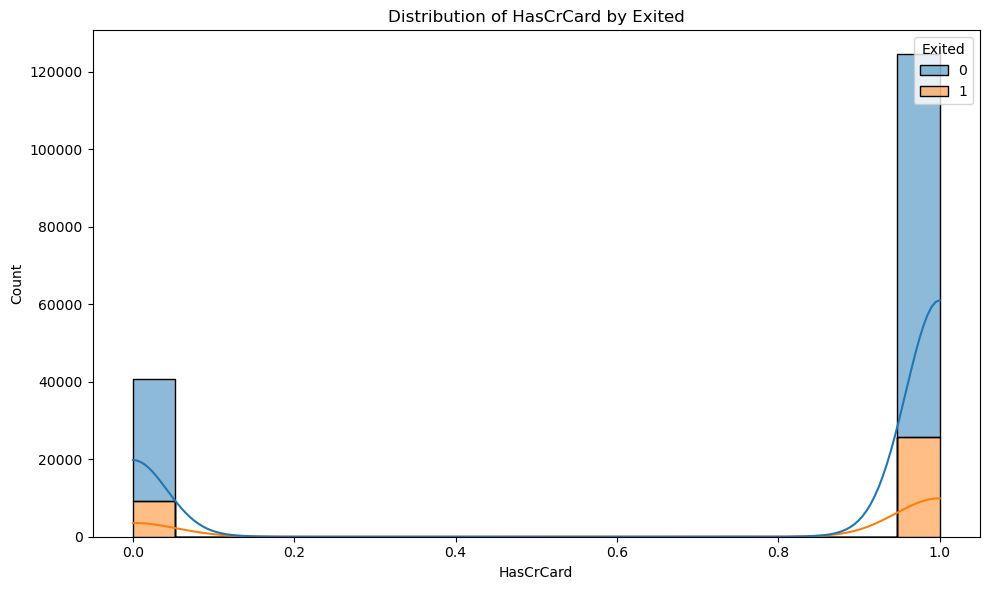

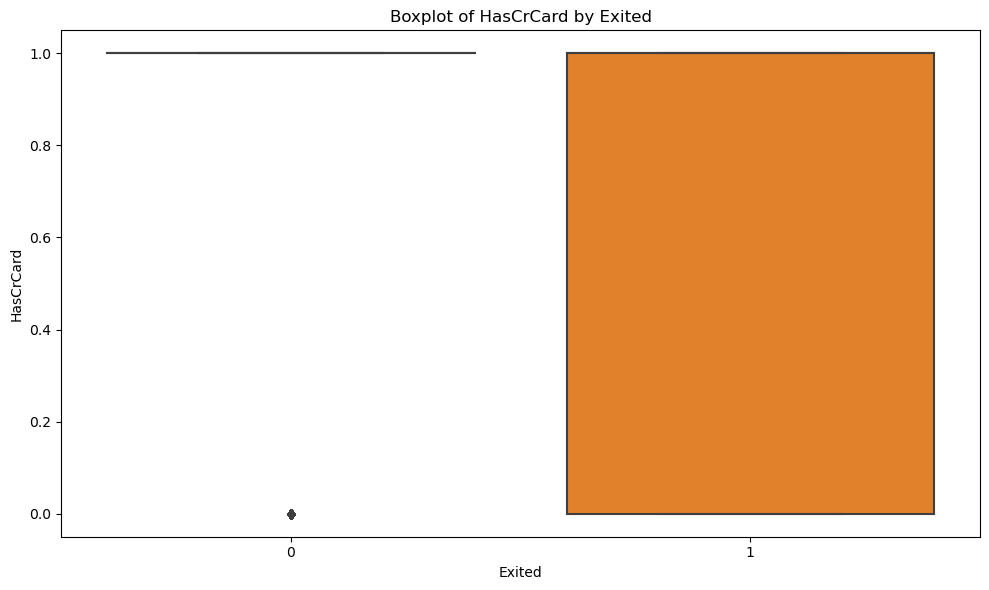

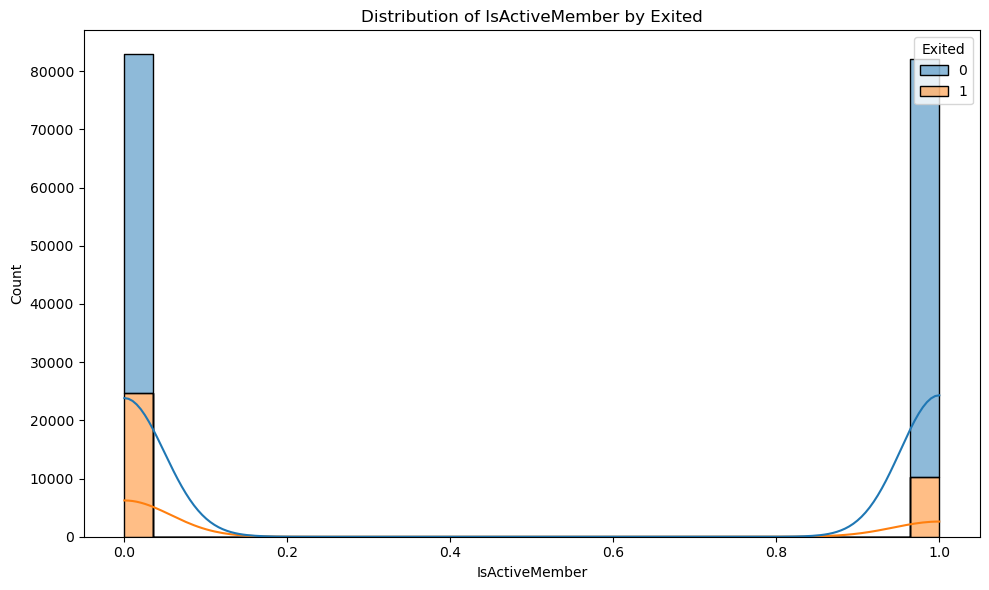

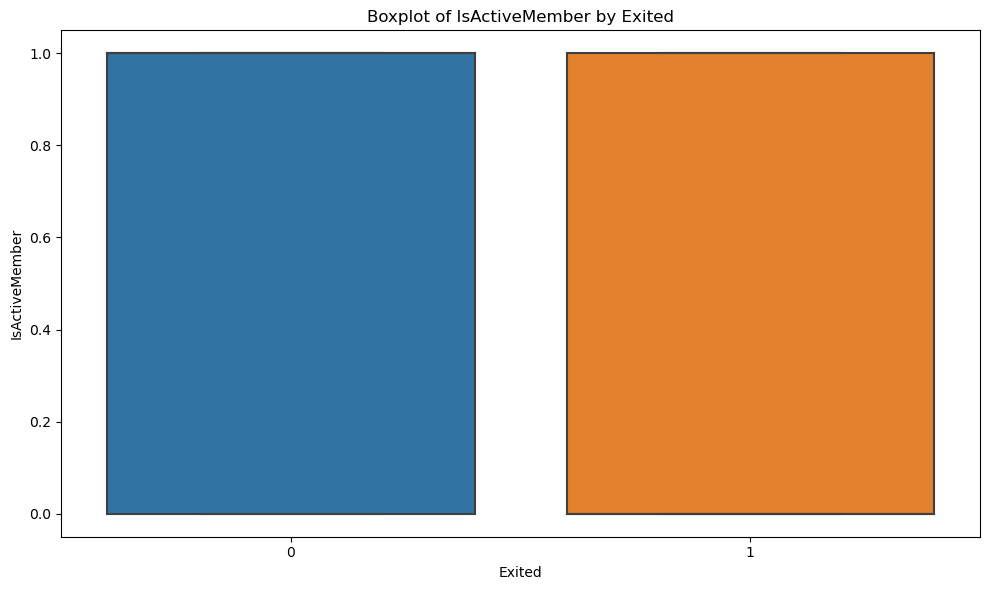

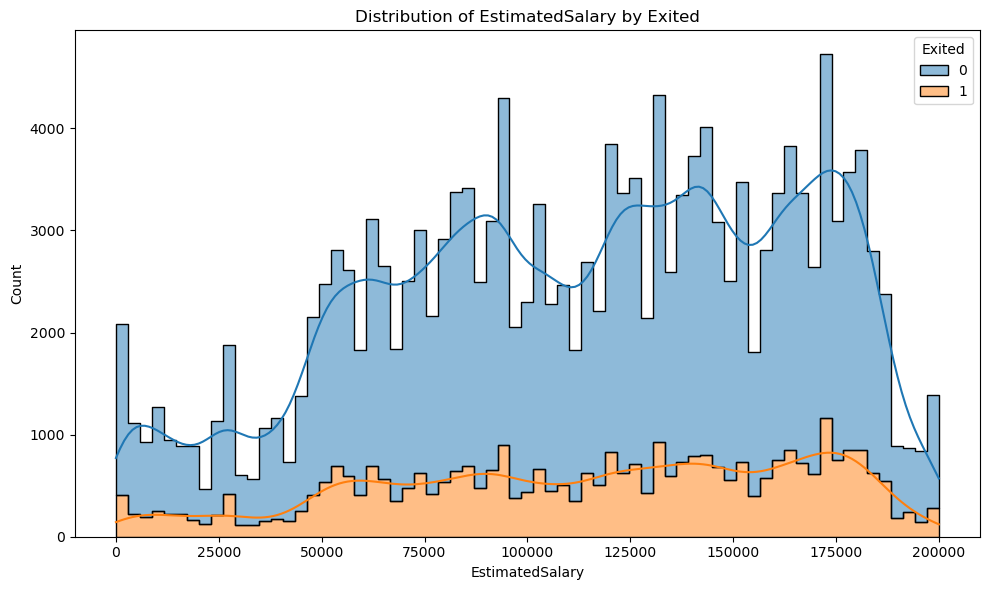

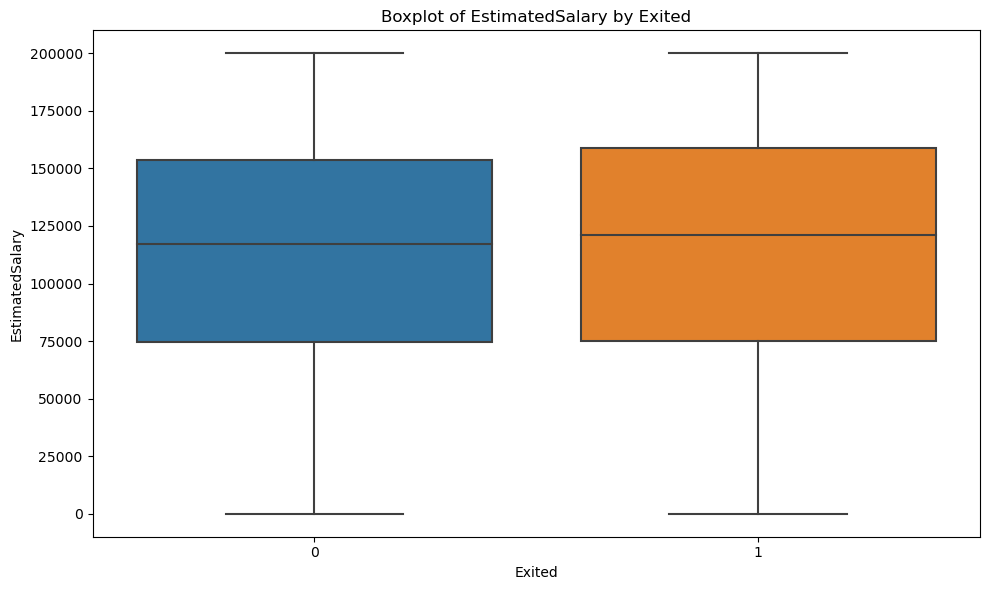

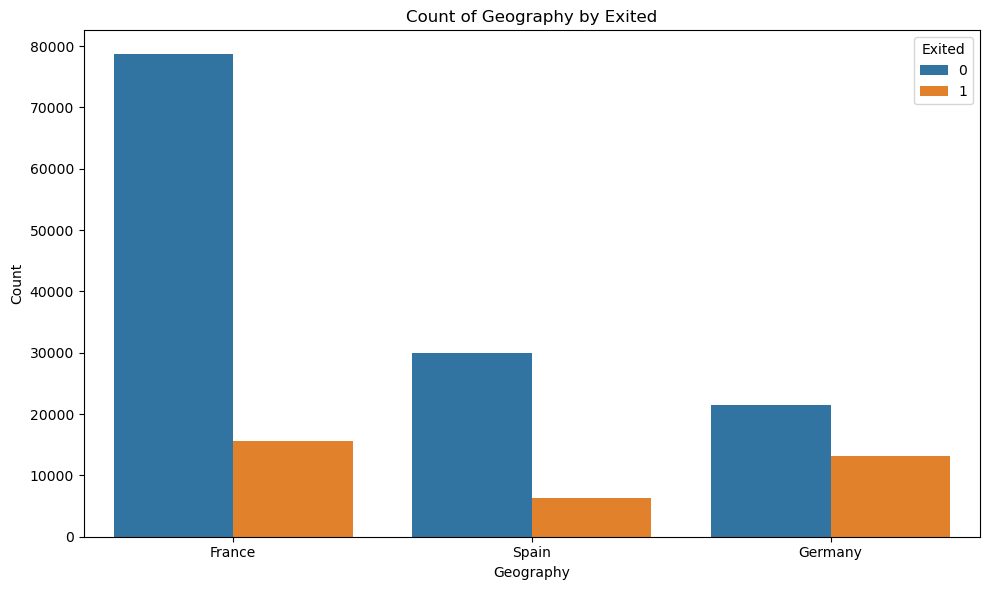

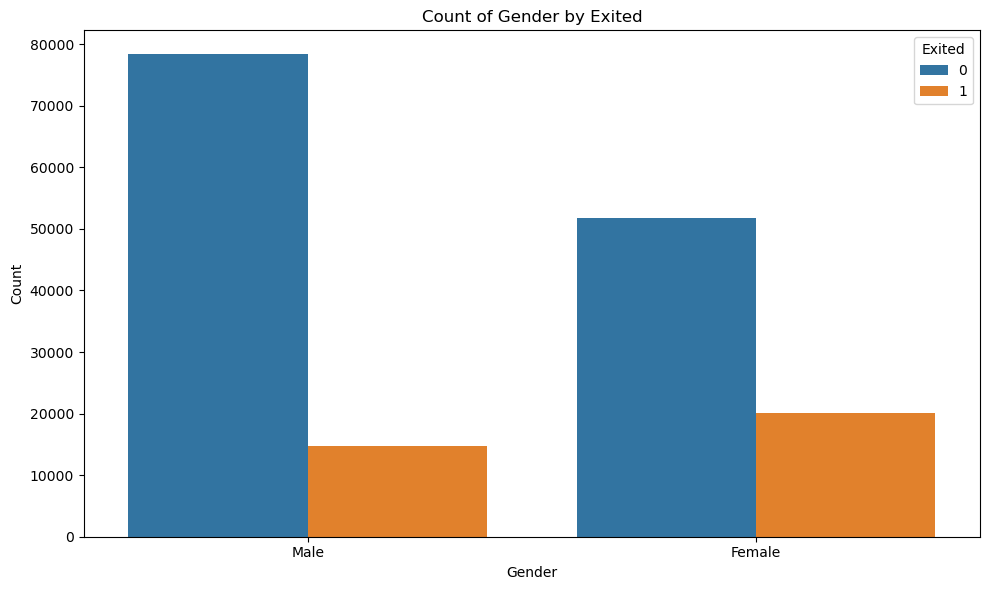

In [14]:
eda_summary(data, "Exited")

## Feature Engineering

### Bucketize!

Let's define the binning strategy for each column as follows:

* Age: We can create age groups that might be relevant to your analysis, such as 18-30, 31-45, 46-60, and 60+.
* Tenure: Since tenure usually ranges from 0 to a certain number of years (often 10 or less in banking datasets), we can  create bins to represent different lengths of relationship with the bank.
* Balance: For balance, we might create bins based on distribution - low balance, medium balance, high balance, etc.
* EstimatedSalary: Similar to balance, we can bin salaries into categories like low, medium, high.

The approach to bucketing CreditScore would depend on the score range and the specific goals of the analysis. A common FICO score range is 300 to 850, and a typical bucketing approach might be:

    300-579: Poor
    580-669: Fair
    670-739: Good
    740-799: Very Good
    800-850: Excellent

In [15]:
age_bins = [17, 30, 45, 60, 120]
age_labels = ["18-30", "31-45", "46-60", "60+"]

In [16]:
tenure_bins = [-1, 2, 5, 8, 10, 1000]
tenure_labels = ["0-2", "3-5", "6-8", "9-10", "10+"]

Bucketize Age and Tenure

In [17]:
data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels)
data["TenureGroup"] = pd.cut(data["Tenure"], bins=tenure_bins, labels=tenure_labels)

Bucketize Estimated Salary

In [18]:
data['EstimatedSalary'].describe()

count    165034.000000
mean     112574.822734
std       50292.865585
min          11.580000
25%       74637.570000
50%      117948.000000
75%      155152.467500
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [19]:
salary_bins = [0, 50000, 100000, 150000, 200000, float("inf")]
salary_bin_labels = ['0_50k', '50k_100k', '100k_150k', '150k_200k', '200k+']
data['SalaryRange'] = pd.cut(data['EstimatedSalary'], bins=salary_bins, labels=salary_bin_labels, include_lowest=True)

Bucketize Balance

In [20]:
balance_bins = [float("-inf"), 0, 50_000, 100_000, 150_000, 200_000, float("inf")]
balance_labels = ["zero", "low", "medium", "high", "very_high", "over_200000"]

In [21]:
data["BalanceGroup"] = pd.cut(data["Balance"], bins=balance_bins, labels=balance_labels)

Bucketize CreditScore

In [22]:
credit_bins = [299, 579, 669, 739, 799, 850]  # Defining the edges of each bin
credit_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']  # Corresponding labels for each bin
data['CreditScoreCategory'] = pd.cut(data['CreditScore'], bins=credit_bins, labels=credit_labels, include_lowest=True)

### Results

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   CreditScore          165034 non-null  float64 
 1   Geography            165034 non-null  object  
 2   Gender               165034 non-null  object  
 3   Age                  165034 non-null  int32   
 4   Tenure               165034 non-null  int64   
 5   Balance              165034 non-null  float64 
 6   NumOfProducts        165034 non-null  int64   
 7   HasCrCard            165034 non-null  int32   
 8   IsActiveMember       165034 non-null  int32   
 9   EstimatedSalary      165034 non-null  float64 
 10  Exited               165034 non-null  int64   
 11  AgeGroup             165034 non-null  category
 12  TenureGroup          165034 non-null  category
 13  SalaryRange          165034 non-null  category
 14  BalanceGroup         165034 non-null  category
 15  

In [24]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,TenureGroup,SalaryRange,BalanceGroup,CreditScoreCategory
0,668.0,France,Male,33,3,0.00,2,1,0,181449.97,0,31-45,3-5,150k_200k,zero,Fair
1,627.0,France,Male,33,1,0.00,2,1,1,49503.50,0,31-45,0-2,0_50k,zero,Fair
2,678.0,France,Male,40,10,0.00,2,1,0,184866.69,0,31-45,9-10,150k_200k,zero,Good
3,581.0,France,Male,34,2,148882.54,1,1,1,84560.88,0,31-45,0-2,50k_100k,high,Fair
4,716.0,Spain,Male,33,5,0.00,2,1,1,15068.83,0,31-45,3-5,0_50k,zero,Good


In [25]:
data[data["SalaryRange"] == "200k+"]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,TenureGroup,SalaryRange,BalanceGroup,CreditScoreCategory


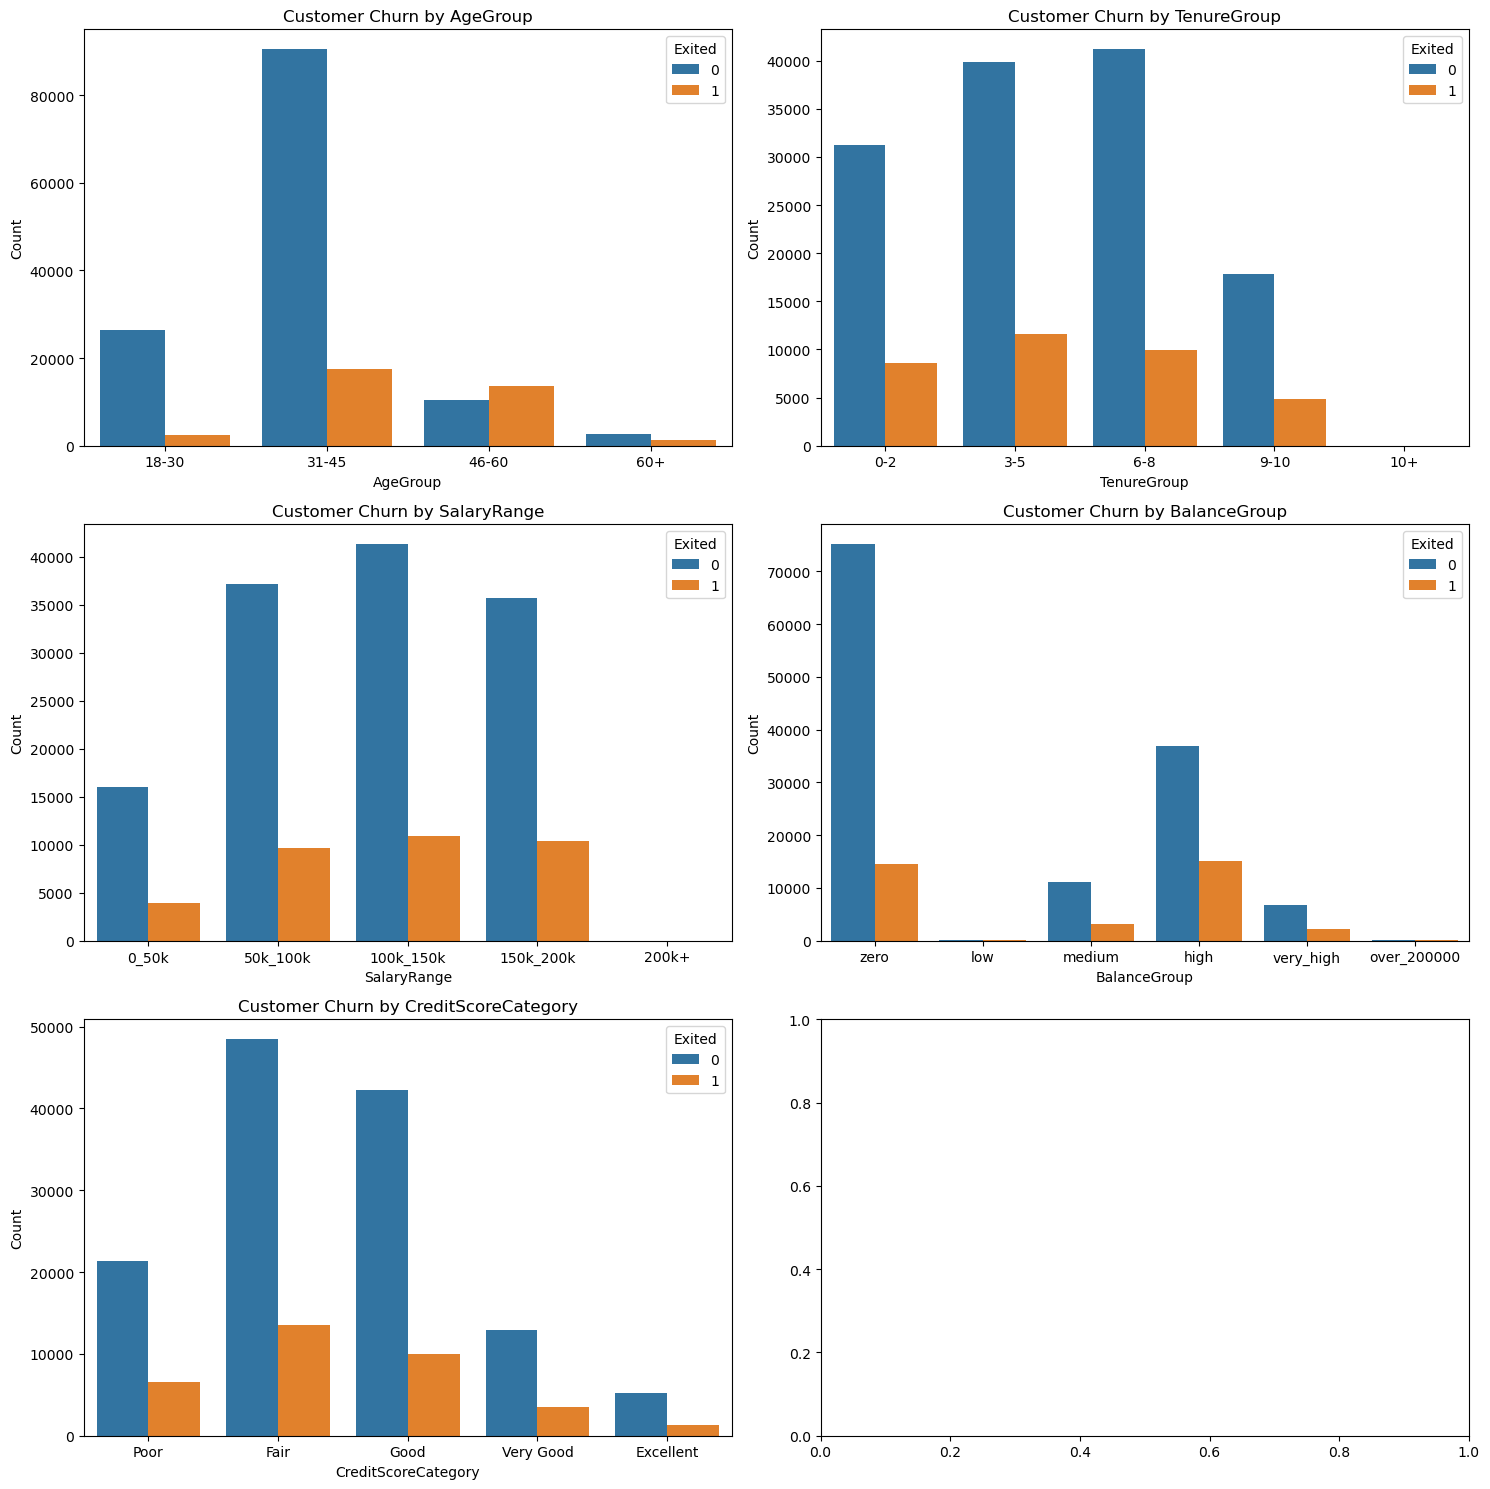

In [26]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Prepare a grid for plotting
axes = axes.flatten()  # Flatten the grid to iterate over it easily
categories = ['AgeGroup', 'TenureGroup', 'SalaryRange', 'BalanceGroup', 'CreditScoreCategory']

for ax, category in zip(axes[:-1], categories):  # The last plot space will be left empty
    sns.countplot(x=category, hue='Exited', data=data, ax=ax)
    ax.set_title(f'Customer Churn by {category}')
    ax.set_xlabel(category)
    ax.set_ylabel('Count')
    ax.legend(title='Exited', loc='upper right')

plt.tight_layout()
plt.show()

## Data Processing

Goal:
* Insert missing values
* Split into training and testing sets.

### Dataset split

In [27]:
X = data.drop(["AgeGroup","SalaryRange","BalanceGroup","TenureGroup","CreditScoreCategory"]+["Exited"], axis=1)
y = data["Exited"]

In [28]:
X.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668.0,France,Male,33,3,0.0,2,1,0,181449.97
1,627.0,France,Male,33,1,0.0,2,1,1,49503.50


In [29]:
X.shape, y.shape

((165034, 10), (165034,))

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  int32  
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int32  
 8   IsActiveMember   165034 non-null  int32  
 9   EstimatedSalary  165034 non-null  float64
dtypes: float64(3), int32(3), int64(2), object(2)
memory usage: 10.7+ MB


In [31]:
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64

### Train Test Split

80% training, 20% test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [33]:
print("Train ->", "X:", X_train.shape, "y:",y_train.shape)
print("Test ->", "X:", X_test.shape, "y:",y_test.shape)
print("Total Shape:", X_train.shape[0] + X_test.shape[0])

Train -> X: (132027, 10) y: (132027,)
Test -> X: (33007, 10) y: (33007,)
Total Shape: 165034


In [34]:
y_train.value_counts()

Exited
0    104061
1     27966
Name: count, dtype: int64

In [35]:
y_test.value_counts()

Exited
0    26052
1     6955
Name: count, dtype: int64

### Create Missing Values

Introduce random missing values to each column in a **% of the Train Dataset.**

In [36]:
np.random.seed(42)  # For reproducibility
def create_missingness(df, missing_rate=0.1):
    """
    Introduces random missing values to each column in the DataFrame based on the given percentage.
    """
    df_copy = df.copy()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    for column in df.columns:
        missing_indices = np.random.choice(df.index, size=int(len(df) * missing_rate), replace=False)
        df_copy.loc[missing_indices, column] = np.nan
    return df_copy

Example usage:

In [37]:
X_train_missing = create_missingness(X_train)

In [38]:
print("\n% of Missing values in train:")
print((X_train_missing.isnull().sum() / len(X_train_missing)) * 100)


% of Missing values in train:
CreditScore        9.99947
Geography          9.99947
Gender             9.99947
Age                9.99947
Tenure             9.99947
Balance            9.99947
NumOfProducts      9.99947
HasCrCard          9.99947
IsActiveMember     9.99947
EstimatedSalary    9.99947
dtype: float64


## Baseline Model

We will develop a Tree model as a performance baseline and use the feature importance attribute to understand better how each contributes to the predictions. We will train the tree without any data imputation. We will drop rows with missing values.

### Drop Rows With Missing Values

In [39]:
X_train_clean = X_train_missing.dropna(inplace=False)
y_train_clean = y.loc[X_train_clean.index]

In [40]:
print("\nTraining dataset after dropping rows:\n")
X_train_clean.info()


Training dataset after dropping rows:

<class 'pandas.core.frame.DataFrame'>
Index: 46145 entries, 164766 to 121958
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      46145 non-null  float64
 1   Geography        46145 non-null  object 
 2   Gender           46145 non-null  object 
 3   Age              46145 non-null  float64
 4   Tenure           46145 non-null  float64
 5   Balance          46145 non-null  float64
 6   NumOfProducts    46145 non-null  float64
 7   HasCrCard        46145 non-null  float64
 8   IsActiveMember   46145 non-null  float64
 9   EstimatedSalary  46145 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.9+ MB


In [41]:
print("\nTarget feature % distribution after dropping rows:")

print((y_train_clean.value_counts() / len(y_train_clean)) * 100)
print(y_train_clean.value_counts())


Target feature % distribution after dropping rows:
Exited
0    78.749594
1    21.250406
Name: count, dtype: float64
Exited
0    36339
1     9806
Name: count, dtype: int64


### Baseline Pipeline Definition

In [42]:
def get_baseline_pipeline(X) -> Pipeline:
    random_state = 42
    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns
    numerical_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    classifier = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', classifier)])
    return pipeline

### Train

In [43]:
pipeline = get_baseline_pipeline(X_train_clean)
pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

### Evaluate

In [44]:
def print_report(y_true, y_pred, name):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f"precision {name}: ", round(precision,6))
    print(f"recall {name}: ", round(recall, 6))
    print(f"f1-score {name}: ",  round(f1, 6))

In [45]:
train_preds = pipeline.predict(X_train_clean)
test_preds = pipeline.predict(X_test)
print_report(y_train_clean, train_preds, "training")
print_report(y_test, test_preds, "validation")

precision training:  0.999796
recall training:  0.999592
f1-score training:  0.999694
precision validation:  0.718026
recall validation:  0.548095
f1-score validation:  0.621657


The performance metrics suggest that the model is overfitting to the training dataset. Before moving on to imputation performance, we will do a quick hyperparameter tuning to find the best parameters for the Random Forest model.

## Hyperparameter Tuning

Let's start by defining the parameter space

In [46]:
param_dist = {
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    'classifier__n_estimators': np.arange(20, 100),  # Number of trees
    'classifier__max_depth': [None] + list(np.arange(4, 20)),         # Maximum depth of each tree
    'classifier__min_samples_split': np.arange(2, 20), # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': np.arange(1, 20),  # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_samples': [None] + [0.2,0.4,0.6,0.8],
}

Perform the search

In [47]:
random_state = 42
estimator = get_baseline_pipeline(X_train_clean)
random_search =RandomizedSearchCV(
    estimator=estimator, 
    param_distributions=param_dist,
    scoring='f1',
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=random_state,
    n_jobs=-1
)

In [48]:
random_search.fit(X_train_clean, y_train_clean)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore')...
                                        'classifier__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'classifier__n_estimators': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   random_state=42, scoring='f1', verbose=1)

In [49]:
# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'classifier__n_estimators': 68, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 3, 'classifier__max_samples': None, 'classifier__max_features': None, 'classifier__max_depth': 8, 'classifier__criterion': 'entropy'}
Best score: 0.6347582694026537


### Tuned Tree

In [50]:
def get_tuned_pipeline(X) -> Pipeline:
    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns
    numerical_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    classifier = RandomForestClassifier(
        criterion='entropy', 
        n_estimators=75,
        min_samples_split=6,
        min_samples_leaf=3,
        max_depth=8,
        max_samples=None,
        max_features=None,
        n_jobs=-1,
        random_state=42
    )
    pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', classifier)])
    return pipeline

In [51]:
pipeline = get_tuned_pipeline(X_train_clean)
pipeline.fit(X_train_clean, y_train_clean)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features=None, min_samples_leaf=3,
                                        min_samples_split=6, n_estimators=75,
                                        n_jobs=-1, random_state=42))])

In [52]:
train_preds = pipeline.predict(X_train_clean)
test_preds = pipeline.predict(X_test)
print_report(y_train_clean, train_preds, "training")
print_report(y_test, test_preds, "test")

precision training:  0.756559
recall training:  0.579339
f1-score training:  0.656194
precision test:  0.734212
recall test:  0.568368
f1-score test:  0.640733


### Feature Importance

The feature importance from a RandomForestClassifier represents the relative importance of each feature in predicting the target variable. It indicates how much each feature contributes to the overall predictive power of the model.

The values are calculated during the training of the random forest algorithm. The higher the value, the more important the feature is for predicting the target variable. It's important to note that feature importance is a relative measure within the context of the model and dataset.

In [53]:
# Access the RandomForestClassifier from the pipeline
rf_classifier = pipeline.named_steps['classifier']

# Access feature importances
feature_importances = rf_classifier.feature_importances_

# Get feature names after preprocessing
numerical_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out()
feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

              Feature  Importance
1                 Age    0.366571
4       NumOfProducts    0.328335
6      IsActiveMember    0.098372
3             Balance    0.084005
9   Geography_Germany    0.032220
7     EstimatedSalary    0.026860
0         CreditScore    0.025458
11      Gender_Female    0.012659
12        Gender_Male    0.011760
2              Tenure    0.008675
5           HasCrCard    0.002427
8    Geography_France    0.001929
10    Geography_Spain    0.000729


## Missing Values Imputation

the kNN pipeline is computationally  expensive. So, we'll use a sample of 70% from the training dataset with the missing values to speed up experimentation

In [54]:
X_sample, _, y_sample, _ = train_test_split(X_train_missing, y_train, test_size=0.3, random_state=45, shuffle=True)

In [55]:
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92418 entries, 140008 to 89153
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      83189 non-null  float64
 1   Geography        83202 non-null  object 
 2   Gender           83193 non-null  object 
 3   Age              83161 non-null  float64
 4   Tenure           83049 non-null  float64
 5   Balance          83185 non-null  float64
 6   NumOfProducts    83170 non-null  float64
 7   HasCrCard        83103 non-null  float64
 8   IsActiveMember   83201 non-null  float64
 9   EstimatedSalary  83224 non-null  float64
dtypes: float64(8), object(2)
memory usage: 7.8+ MB


In [56]:
print("\n% of Missing values in sample:")
print((X_sample.isnull().sum() / len(X_sample)) * 100)


% of Missing values in sample:
CreditScore         9.986150
Geography           9.972083
Gender              9.981822
Age                10.016447
Tenure             10.137636
Balance             9.990478
NumOfProducts      10.006709
HasCrCard          10.079205
IsActiveMember      9.973165
EstimatedSalary     9.948278
dtype: float64


# Results

## Model Performance Results by Imputation

### KNN Imputer

In [57]:
def knn_imputer_pipe(X):
    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns
    
    
    # Updated numerical pipeline to include KNNImputer
    numerical_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # From hyperparameter tuning
    classifier = RandomForestClassifier(
        criterion='entropy', 
        n_estimators=75,
        min_samples_split=6,
        min_samples_leaf=3,
        max_depth=8,
        max_samples=None,
        max_features=None,
        n_jobs=-1,
        random_state=42
    )
    
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', classifier)
    ])
    return pipeline

In [58]:
knn_imputer_pipe(X_sample)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features=None, min_samples_leaf=3,
                                        min_samples_split=6, n_estimators=75,
                                        n_jobs=-1, random_state=42))])

In [59]:
start_time = time()
knn_imputer = knn_imputer_pipe(X_sample)
knn_imputer.fit(X_sample, y_sample)
end_time = time()
execution_time = end_time - start_time
train_preds = knn_imputer.predict(X_sample)
test_preds = knn_imputer.predict(X_test)
print("Performance of kNN-imputation:")
print_report(y_sample, train_preds, "training dataset")
print_report(y_test, test_preds, "test dataset")
print("Execution time:", round(execution_time,2), "seconds")

Performance of kNN-imputation:
precision training dataset:  0.744926
recall training dataset:  0.501914
f1-score training dataset:  0.599738
precision test dataset:  0.743217
recall test dataset:  0.551402
f1-score test dataset:  0.633099
Execution time: 248.85 seconds


### Estimate Missing Features from others

In [67]:
def iterative_imputer_pipe(X):
    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns
    
    
    # Updated numerical pipeline to include KNNImputer
    numerical_pipeline = Pipeline([
        ('imputer', IterativeImputer(max_iter=10, random_state=42)),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # From hyperparameter tuning
    classifier = RandomForestClassifier(
        criterion='entropy', 
        n_estimators=75,
        min_samples_split=6,
        min_samples_leaf=3,
        max_depth=8,
        max_samples=None,
        max_features=None,
        n_jobs=-1,
        random_state=42
    )
    
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', classifier)
    ])
    return pipeline

In [68]:
start_time = time()
iter_imputer = iterative_imputer_pipe(X_sample)
iter_imputer.fit(X_sample, y_sample)
end_time = time()
execution_time = end_time - start_time
train_preds = iter_imputer.predict(X_sample)
test_preds = iter_imputer.predict(X_test)
print("Performance of Iterative Imputation:")
print_report(y_sample, train_preds, "training dataset")
print_report(y_test, test_preds, "test dataset")
print("Execution time:", round(execution_time,2) , "seconds")

Performance of Iterative Imputation:
precision training dataset:  0.743096
recall training dataset:  0.513497
f1-score training dataset:  0.607321
precision test dataset:  0.738091
recall test dataset:  0.559166
f1-score test dataset:  0.636289
Execution time: 4.08 seconds


### Mean Imputation

In [69]:
def mean_imputer_pipe(X):
    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns
    
    
    # Updated numerical pipeline to include KNNImputer
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # From hyperparameter tuning
    classifier = RandomForestClassifier(
        criterion='entropy', 
        n_estimators=75,
        min_samples_split=6,
        min_samples_leaf=3,
        max_depth=8,
        max_samples=None,
        max_features=None,
        n_jobs=-1,
        random_state=42
    )
    
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', classifier)
    ])
    return pipeline

In [70]:
mean_imputer_pipe(X_sample)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Geography', 'Gender'], dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features=None, min_samples_leaf=3,
                                        min_samples_split=6, n_estimators=75,
                                        n_jobs=-1, random_state=42))])

In [71]:
start_time = time()
mean_imputer = mean_imputer_pipe(X_sample)
mean_imputer.fit(X_sample, y_sample)
end_time = time()
execution_time = end_time - start_time
train_preds = mean_imputer.predict(X_sample)
test_preds = mean_imputer.predict(X_test)
print("Performance of Imputation with Mean:")
print_report(y_sample, train_preds, "training dataset")
print_report(y_test, test_preds, "test dataset")
print("Execution time:", round(execution_time,2), "seconds")

Performance of Imputation with Mean:
precision training dataset:  0.739603
recall training dataset:  0.51365
f1-score training dataset:  0.606258
precision test dataset:  0.741942
recall test dataset:  0.552696
f1-score test dataset:  0.633487
Execution time: 2.77 seconds


## Imputation Strategies Error Results

For discrete integer feature, such as CreditScore, Age, Tenure, NumOfProducts, HasCrCard, and IsActiveMember, even though they are numerical, they represent discrete categories or states rather than continuous quantities. Thus, for categorical and discrete features we will use the Accuracy to measure the imputation error for these features. For continous features we will use the Mean Absolute Error.

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  int32  
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int32  
 8   IsActiveMember   165034 non-null  int32  
 9   EstimatedSalary  165034 non-null  float64
dtypes: float64(3), int32(3), int64(2), object(2)
memory usage: 10.7+ MB


In [73]:
corrupted_df = create_missingness(X)
# Convert non-NA values to integers while keeping NAs
columns_to_convert = ['Age', 'HasCrCard', 'IsActiveMember', 'Tenure', 'NumOfProducts']
for column in columns_to_convert:
    corrupted_df[column] = corrupted_df[column].astype('Int64')  # Note the capital 'I'

In [74]:
corrupted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      148531 non-null  float64
 1   Geography        148531 non-null  object 
 2   Gender           148531 non-null  object 
 3   Age              148531 non-null  Int64  
 4   Tenure           148531 non-null  Int64  
 5   Balance          148531 non-null  float64
 6   NumOfProducts    148531 non-null  Int64  
 7   HasCrCard        148531 non-null  Int64  
 8   IsActiveMember   148531 non-null  Int64  
 9   EstimatedSalary  148531 non-null  float64
dtypes: Int64(5), float64(3), object(2)
memory usage: 13.4+ MB


In [75]:
corrupted_df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668.0,France,Male,33,3,0.00,2,1,0,181449.97
1,627.0,NaN,Male,33,1,0.00,<NA>,1,1,49503.50
2,678.0,France,Male,40,10,0.00,2,1,0,184866.69
3,581.0,France,Male,34,2,148882.54,1,1,1,NaN
4,716.0,Spain,Male,33,5,0.00,2,<NA>,<NA>,NaN


In [84]:
def measure_error_imputation(X_original, X_with_missing):
    # Define feature types
    numerical_features = X_with_missing.select_dtypes(include=["float64"]).columns
    discrete_features = X_with_missing.select_dtypes(include=["Int64"]).columns
    categorical_features = X_with_missing.select_dtypes(include=["object"]).columns
    
    # Pipelines for imputation
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    discrete_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('discrete', discrete_pipeline, discrete_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # Fit and transform the data with missing values
    X_missing_imputed = preprocessor.fit_transform(X_with_missing)
    X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=numerical_features.tolist() + discrete_features.tolist() + categorical_features.tolist(), index=X_with_missing.index)
    
    # Initialize dictionary to store errors
    errors = {}
    
    print("Errors using Mean and most_frequent Imputation:\n")
    
    # Measure MAE for numerical features
    for col in numerical_features:
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        error = mean_absolute_error(original_values, imputed_values)
        errors[col] = error
        print(f'MAE for {col}:', round(error,4))
        
    # Measure Accuracy for discrete and categorical features
    for col in discrete_features.tolist() + categorical_features.tolist():
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        # For accuracy calculation, ensure the data type aligns for comparison
        if col in discrete_features:
            imputed_values = imputed_values.astype('Int64')  # Ensure the type is integer for discrete fields
        if original_values.dtype == 'object':  # For categorical fields, ensure string type
            original_values = original_values.astype(str)
            imputed_values = imputed_values.astype(str)
        accuracy = accuracy_score(original_values, imputed_values)
        errors[col] = accuracy
        print(f'Accuracy for {col}:', round(accuracy, 4))
    
    return errors


In [85]:
_ = measure_error_imputation(X, corrupted_df)

Errors using Mean and most_frequent Imputation:

MAE for CreditScore: 64.6008
MAE for Balance: 60339.0862
MAE for EstimatedSalary: 42788.1254
Accuracy for Age: 0.0535
Accuracy for Tenure: 0.1113
Accuracy for NumOfProducts: 0.5047
Accuracy for HasCrCard: 0.7519
Accuracy for IsActiveMember: 0.5065
Accuracy for Geography: 0.5679
Accuracy for Gender: 0.5628


In [86]:
def measure_error_mice(X_original, X_with_missing):
    # Define feature types
    numerical_features = X_with_missing.select_dtypes(include=["float64"]).columns
    discrete_features = X_with_missing.select_dtypes(include=["Int64"]).columns
    categorical_features = X_with_missing.select_dtypes(include=["object"]).columns
    
    # Pipelines for imputation
    numerical_pipeline = Pipeline([
        ('imputer', IterativeImputer(max_iter=5, random_state=0))
    ])
    discrete_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('discrete', discrete_pipeline, discrete_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # Fit and transform the data with missing values
    X_missing_imputed = preprocessor.fit_transform(X_with_missing)
    X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=numerical_features.tolist() + discrete_features.tolist() + categorical_features.tolist(), index=X_with_missing.index)
    
    # Initialize dictionary to store errors
    errors = {}
    
    print("Errors using IterativeImputer and most_frequent Imputation:\n")
    # Measure MAE for numerical features
    for col in numerical_features:
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        error = mean_absolute_error(original_values, imputed_values)
        errors[col] = error
        print(f'MAE for {col}:', round(error,4))
        
    # Measure Accuracy for discrete and categorical features
    for col in discrete_features.tolist() + categorical_features.tolist():
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        # For accuracy calculation, ensure the data type aligns for comparison
        if col in discrete_features:
            imputed_values = imputed_values.astype('Int64')  # Ensure the type is integer for discrete fields
        if original_values.dtype == 'object':  # For categorical fields, ensure string type
            original_values = original_values.astype(str)
            imputed_values = imputed_values.astype(str)
        accuracy = accuracy_score(original_values, imputed_values)
        errors[col] = accuracy
        print(f'Accuracy for {col}:', round(accuracy, 4))
    
    return errors

In [87]:
_ = measure_error_mice(X, corrupted_df)

Errors using IterativeImputer and most_frequent Imputation:

MAE for CreditScore: 64.6002
MAE for Balance: 60333.7625
MAE for EstimatedSalary: 42790.3325
Accuracy for Age: 0.0535
Accuracy for Tenure: 0.1113
Accuracy for NumOfProducts: 0.5047
Accuracy for HasCrCard: 0.7519
Accuracy for IsActiveMember: 0.5065
Accuracy for Geography: 0.5679
Accuracy for Gender: 0.5628


In [82]:
def measure_error_knn(X_original, X_with_missing):
    # Define feature types
    numerical_features = X_with_missing.select_dtypes(include=["float64"]).columns
    discrete_features = X_with_missing.select_dtypes(include=["Int64"]).columns
    categorical_features = X_with_missing.select_dtypes(include=["object"]).columns
    
    # Pipelines for imputation
    numerical_pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ])
    discrete_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Combine preprocessing pipelines
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('discrete', discrete_pipeline, discrete_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    # Fit and transform the data with missing values
    X_missing_imputed = preprocessor.fit_transform(X_with_missing)
    X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=numerical_features.tolist() + discrete_features.tolist() + categorical_features.tolist(), index=X_with_missing.index)
    
    # Initialize dictionary to store errors
    errors = {}
    
    print("Errors using KNNImputer and most_frequent Imputation:\n")
    # Measure MAE for numerical features
    for col in numerical_features:
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        error = mean_absolute_error(original_values, imputed_values)
        errors[col] = error
        print(f'MAE for {col}:', round(error,4))
        
    # Measure Accuracy for discrete and categorical features
    for col in discrete_features.tolist() + categorical_features.tolist():
        missing_indices = X_with_missing[col].isnull()
        original_values = X_original.loc[missing_indices, col]
        imputed_values = X_missing_imputed_df.loc[missing_indices, col]
        # For accuracy calculation, ensure the data type aligns for comparison
        if col in discrete_features:
            imputed_values = imputed_values.astype('Int64')  # Ensure the type is integer for discrete fields
        if original_values.dtype == 'object':  # For categorical fields, ensure string type
            original_values = original_values.astype(str)
            imputed_values = imputed_values.astype(str)
        accuracy = accuracy_score(original_values, imputed_values)
        errors[col] = accuracy
        print(f'Accuracy for {col}:', round(accuracy, 4))
    
    return errors

In [83]:
_ = measure_error_knn(X, corrupted_df)

Errors using KNNImputer and most_frequent Imputation:

MAE for CreditScore: 69.2711
MAE for Balance: 58516.1682
MAE for EstimatedSalary: 45165.175
Accuracy for Age: 0.0535
Accuracy for Tenure: 0.1113
Accuracy for NumOfProducts: 0.5047
Accuracy for HasCrCard: 0.7519
Accuracy for IsActiveMember: 0.5065
Accuracy for Geography: 0.5679
Accuracy for Gender: 0.5628
